# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [68]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-03-14 06:40:16--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat.2’

notMNIST_small.mat. 100%[===================>] 112.14M  37.3MB/s    in 3.0s    

2023-03-14 06:40:19 (37.3 MB/s) - ‘notMNIST_small.mat.2’ saved [117586976/117586976]



In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

## Data Loading

In [70]:
data = io.loadmat('notMNIST_small.mat')

In [71]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 10 11:38:32 2011',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   1.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 215., ...,   0., 160., 124.],
         [255.,   0., 227., ...,   0., 122.,  72.],
         [255.,   0., 156., ...,   0.,   0.,  12.]],
 
        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,  19.,   0., ...,   0.,   0.,   0.],
         [  0.,  93.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 255., ...,   0., 255., 255.],
         [255.,   0., 110., ...,   0., 206., 227.],
         [255.,   0.,  21., ...,   0.,   0.,  63.]],
 
        [[  0.,   3.,   0., ...,   0.,   0.,   0.],
         [  0., 167.,   0., ...,   0.,   0.,   0.],
         [  0., 255.,   0., ...,   1.,   1.,   0.],
         ...,
         [255.,   0., 223.

* transform data

In [72]:
x = data['images']
y = data['labels']

In [73]:
x_trans = np.transpose(x, (2, 0, 1))

In [74]:
print( x.shape )
print( x_trans.shape )

(28, 28, 18724)
(18724, 28, 28)


In [75]:
x = np.transpose(x, (2, 0, 1))

* x, y 타입 변환

In [76]:
y = y.astype('int32')
x = x.astype('float32') #/ 255.

* reshape

    - reshape.(sample, x, y, channel) 순서

In [77]:
resolution = 28

x = x.reshape((-1, resolution, resolution, 1))
x.shape

(18724, 28, 28, 1)

* 랜덤하게 문자 시각화

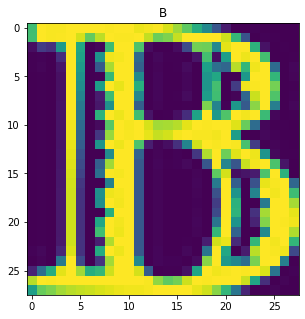

In [78]:
# looking at data; some fonts are strange
rand_n = np.random.randint(0, 18723)

plt.figure(figsize=(5,5))
plt.title( "ABCDEFGHIJ"[y[rand_n]] )
plt.imshow( x[rand_n, :, :, 0])
plt.show()

* 랜덤하게 여러 문자 시각화

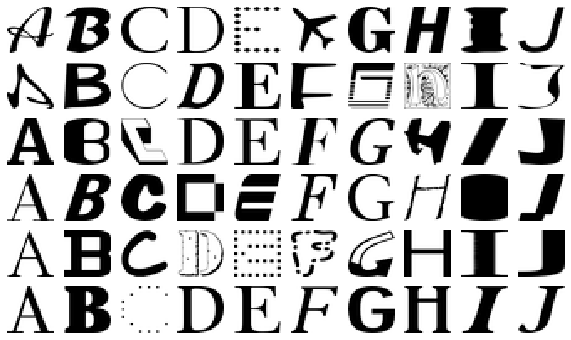

In [79]:
# random letters
classes = 10
rows = 6

fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = x[ y==letter_id ]

    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)), :, :, 0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

* train set / validation set / test set 분리

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2023)

In [82]:
x_train.shape, y_train.shape

((11983, 28, 28, 1), (11983,))

## X : Min-Max Scaling

In [83]:
x_train = x_train/x_train.max()
x_val = x_val/x_train.max()

In [84]:
x_train.max(), x_train.min()

(1.0, 0.0)

## Y : One-Hot Encoding

In [85]:
from tensorflow.keras.utils import to_categorical
u = len(np.unique(y_train))
y_train = to_categorical(y_train, u)
y_val = to_categorical(y_val, u)

## **Data Augmentation**

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [87]:
# 데이터 제너레이터를 선언함!  제너레이팅 규칙과 함께!
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,   # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=True,     # apply ZCA whitening
        rotation_range=20,      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,       # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True)     # randomly flip images

# 어떤 데이터를 바탕으로 제너레이팅 할 것인지, 미리 알려줌! 필수!
datagen.fit(x_train)

# 학습 할 때마다, '실시간'으로 데이터를 생성(뻥튀기 autmentation)하여 학습에 활용하고, 버리고를 반복할 준비!
train_gen = datagen.flow(x_train, y_train, batch_size=128)

## Keras로 자유롭게 CNN 모델링

1. [이 구조를 미니 버전으로 활용해봐도 좋다](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
2. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
3. 컨컨컨풀 컨컨컨풀 컨컨컨풀은 어떠한가!

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential

In [89]:
x_train.shape, y_train.shape

((11983, 28, 28, 1), (11983, 10))

In [93]:
tf.keras.backend.clear_session()

model = Sequential()

model.add( Input(shape=(28,28,1)) )

model.add( Conv2D(filters=64,
                  kernel_size=(3,3),
                  strides=(1,1),
                  padding='same',
                  activation='relu' ))
model.add( Conv2D(filters=64,
                  kernel_size=(3,3),
                  strides=(1,1),
                  padding='same',
                  activation='relu'))

model.add( MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D( filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(Conv2D( filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add( MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D( filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(Conv2D( filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add( MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# model.add(Conv2D( filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation='relu'))
# model.add(Conv2D( filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation='relu'))

# model.add( MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# model.add(Conv2D( filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation='relu'))
# model.add(Conv2D( filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation='relu'))

# model.add( MaxPool2D(pool_size=(2,2)))



model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       1

In [95]:
model.fit(train_gen, epochs=1, validation_data=(x_val, y_val), verbose=1)

94/94 [==============================] - 37s 236ms/step - loss: 1.3844 - accuracy: 0.5783 - val_loss: 41.3258 - val_accuracy: 0.1515


## Early Stopping을 이용한 학습

위의 코드를 참고하여, 5 epoch 전보다 val_loss가 개선되지 않았으면 멈추는 얼리 스토핑 모델링을 하시오.

In [96]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [97]:
model.fit(train_gen, epochs=1000, validation_data=(x_val, y_val), verbose=1, callbacks=[es])

Epoch 1/1000
94/94 [==============================] - 14s 145ms/step - loss: 0.8530 - accuracy: 0.7390 - val_loss: 48.9251 - val_accuracy: 0.1245
Epoch 2/1000
94/94 [==============================] - 14s 147ms/step - loss: 0.7066 - accuracy: 0.7804 - val_loss: 30.9242 - val_accuracy: 0.2844
Epoch 3/1000
94/94 [==============================] - 15s 164ms/step - loss: 0.6445 - accuracy: 0.8035 - val_loss: 34.3002 - val_accuracy: 0.1852
Epoch 4/1000
94/94 [==============================] - 14s 147ms/step - loss: 0.6090 - accuracy: 0.8133 - val_loss: 44.8056 - val_accuracy: 0.1646
Epoch 5/1000
94/94 [==============================] - 14s 151ms/step - loss: 0.5545 - accuracy: 0.8298 - val_loss: 52.8742 - val_accuracy: 0.2046
Epoch 6/1000
94/94 [==============================] - 14s 149ms/step - loss: 0.5165 - accuracy: 0.8405 - val_loss: 58.0861 - val_accuracy: 0.2006
Epoch 7/1000
94/94 [==============================] - 15s 158ms/step - loss: 0.4955 - accuracy: 0.8480 - val_loss: 45.6099 -

* 예측값 생성

In [98]:
y_pred = model.predict(x_test)

118/118 [==============================] - 2s 10ms/step


* 생성한 예측값을 y_test 구조와 같게 만든다

In [99]:
pred_array = np.zeros(shape=(y_pred.shape[0], y_pred.shape[1]))
idx = 0

for arr_val in y_pred :
    # print(arr_val)
    pred_array[idx][arr_val.argmax()] = 1
    idx += 1

In [100]:
pred_array.shape

(3745, 10)

* 성능 평가

In [101]:
from sklearn.metrics import accuracy_score

In [115]:
a = []
for i in pred_array:
  a.append(np.argmax(i))

In [117]:
print( f'{accuracy_score(y_test, a):.4f}' )

0.2764


## 문자 이미지 시각화

In [118]:
import random as rd

In [119]:
character = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

* 실제 성능 확인을 위해 반복 실행!

id = 3
실제 문자 : A
모델의 문자 예측 : A
모델의 문자별 예측 확률 : [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
정답


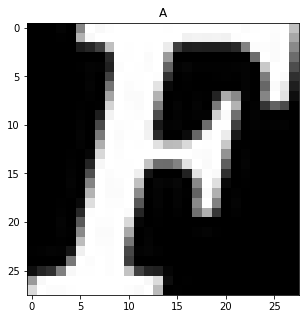

In [120]:
rand_n = rd.randrange(0, 3744)

print(f'id = {rand_n}')
print(f'실제 문자 : {character[y_test[rand_n].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[rand_n].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[rand_n]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[rand_n].argmax() == y_pred[rand_n].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[rand_n].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_test[rand_n].argmax()] )
plt.show()

* 틀린 문자만 확인해봅시다!

In [121]:
t_f = ( y_test.argmax(axis=1) == y_pred.argmax(axis=1) )
false_id = np.where(t_f==False)[0]
false_n = len(false_id)

id = false_id[rd.randrange(0, false_n)]

print(f'id = {id}')
print(f'실제 문자 : {character[y_test[id].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[id].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[id]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[id].argmax() == y_pred[id].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[id].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_pred[id].argmax()] )
plt.show()

AxisError: ignored